In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import pickle


In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2024/05/22 20:10:31 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716408631564, experiment_id='1', last_update_time=1716408631564, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [4]:
categorical = ["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

def load_df(paths: list) -> pd.DataFrame:
    df = pd.concat([pd.read_parquet(path) for path in paths])

    df["duration"] = (df["lpep_dropoff_datetime"] - df["lpep_pickup_datetime"])
    df["duration_min"] = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration_min >= 1) & (df.duration_min < 80)]

    df[categorical] = df[categorical].astype("str")
    
    return df
    

In [5]:
df_train = load_df([
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet", 
])

In [6]:
df_val = load_df(["https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet"])

In [7]:
df_train.shape, df_val.shape

((66193, 22), (62847, 22))

In [8]:
len(df_train), len(df_val)

(66193, 62847)

In [9]:
train_dict = df_train[categorical + numerical].to_dict(orient="records")
val_dict = df_val[categorical + numerical].to_dict(orient="records")

In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)


In [11]:
X_train, X_val

(<66193x471 sparse matrix of type '<class 'numpy.float64'>'
 	with 198579 stored elements in Compressed Sparse Row format>,
 <62847x471 sparse matrix of type '<class 'numpy.float64'>'
 	with 188503 stored elements in Compressed Sparse Row format>)

In [12]:
target = "duration_min"

y_train = df_train[target].values
y_val = df_val[target].values

In [13]:
y_train, y_val

(array([11.01666667,  6.76666667,  6.33333333, ..., 16.        ,
        18.        , 16.        ]),
 array([19.58333333, 17.55      , 23.71666667, ..., 17.        ,
        17.        ,  5.        ]))

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
y_pred = lr.predict(X_train)

In [16]:
y_pred_val = lr.predict(X_val)

/tmp/ipykernel_12517/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/tmp/ipykernel_12517/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


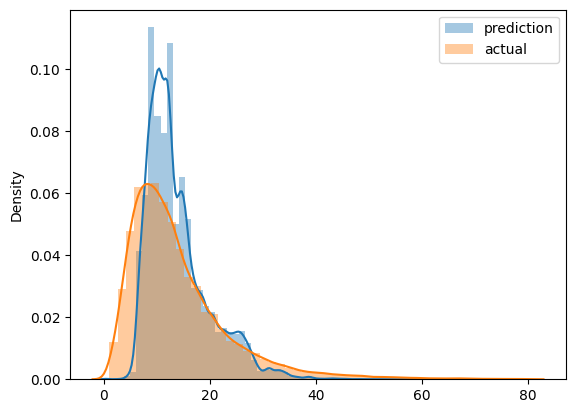

In [17]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [18]:
mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-trackin-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.5579071844409444

/tmp/ipykernel_12517/3483418046.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred_val, label="prediction")
/tmp/ipykernel_12517/3483418046.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label="actual")


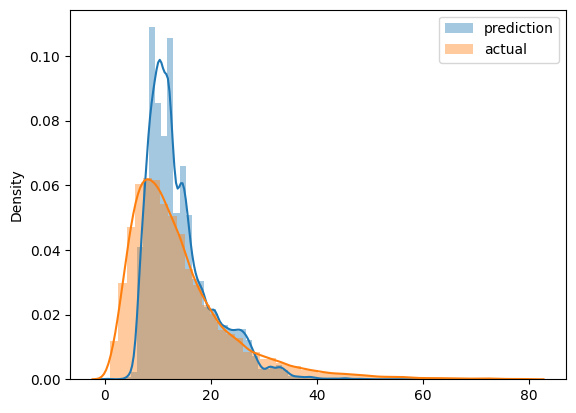

In [19]:
sns.distplot(y_pred_val, label="prediction")
sns.distplot(y_val, label="actual")

plt.legend()

In [20]:
mean_squared_error(y_pred_val, y_val, squared=False)

/home/codespace/anaconda3/envs/exp-trackin-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.908455913853727

In [21]:
with open("models/lin_reg.bin", "wb") as f_out:
    pickle.dump((dv, lr), f_out)

In [28]:
with mlflow.start_run():
    mlflow.set_tag("developer", "horhe")
    mlflow.log_param("train_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("validation_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)


    lr_lasso = Lasso(alpha)
    lr_lasso.fit(X_train, y_train)
    y_pred = lr_lasso.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

/home/codespace/anaconda3/envs/exp-trackin-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
